In [98]:
# we first define the autoencoder's architecture:

from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K
from keras.models import load_model
from keras.callbacks import TensorBoard
import numpy as np
import matplotlib.pyplot as plt

def Encoder():
    input_img = Input(shape=(60, 800, 1))  # adapt this if using `channels_first` image data format   
    e1 = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
    e2 = MaxPooling2D((2, 2), padding='same')(e1)
    e3 = Conv2D(8, (3, 3), activation='relu', padding='same')(e2)
    e4 = MaxPooling2D((3, 2), padding='same')(e3)
    e5 = Conv2D(8, (10, 10), activation='relu', padding='same')(e4)
    e6 = MaxPooling2D((2, 2), padding='same')(e5)
    return Model(input_img, e6)

def Decoder():
    input_img = Input(shape=(5, 100, 8))  # adapt this if using `channels_first` image data format   
    d1 = Conv2D(8, (10, 10), activation='relu', padding='same')(input_img)
    d2 = UpSampling2D((2, 2))(d1)
    d3 = Conv2D(8, (3, 3), activation='relu', padding='same')(d2)
    d4 = UpSampling2D((3, 2))(d3)
    d5 = Conv2D(16, (3, 3), activation='relu', padding='same')(d4)
    d6 = UpSampling2D((2, 2))(d5)
    d7 = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(d6)
    return Model(input_img, d7)

In [99]:
# define input to the model:
x = Input(shape=(60, 800, 1))

# make the model:
autoencoder = Model(x, Decoder()(Encoder()(x)))

# compile the model:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [100]:
# SEE INSIDE THE ENCODER AND DECODER:
Encoder().summary()
Decoder().summary()

# IN FACT, OUT AUTOENCODER WILL BE A CONCATENATION OF TWO MODELS
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_24 (InputLayer)        (None, 60, 800, 1)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 60, 800, 16)       160       
_________________________________________________________________
max_pooling2d_28 (MaxPooling (None, 30, 400, 16)       0         
_________________________________________________________________
conv2d_65 (Conv2D)           (None, 30, 400, 8)        1160      
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 10, 200, 8)        0         
_________________________________________________________________
conv2d_66 (Conv2D)           (None, 10, 200, 8)        6408      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 5, 100, 8)         0         
Total para

In [118]:
# get the Dataset:

import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import scipy.io as sio

# load data from the .mat file:
mat_contents = sio.loadmat('EEG_data.mat')
X = mat_contents['X']
Y = mat_contents['Y']
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.20)
print('Original data type:', x_train.dtype)

# convert to float64 for numerical stability:
x_train = x_train.astype('float64')
y_train = y_train.astype('float64')
x_test = x_test.astype('float64')
y_test = y_test.astype('float64')

# normalize to unit variance and zero mean:
for i in range(x_train.shape[0]):
    x_train[i,:,:] = preprocessing.scale(x_train[i,:,:], axis=1)
    x_train[i,:,:] = preprocessing.minmax_scale(x_train[i,:,:], axis=1)
    y_train[i,:] = preprocessing.scale(y_train[i,:], axis=0)
    y_train[i,:] = preprocessing.minmax_scale(y_train[i,:], axis=0)

for i in range(x_test.shape[0]):
    x_test[i,:,:] = preprocessing.scale(x_test[i,:,:], axis=1)
    x_test[i,:,:] = preprocessing.minmax_scale(x_test[i,:,:], axis=1)
    y_test[i,:] = preprocessing.scale(y_test[i,:], axis=0)
    y_test[i,:] = preprocessing.minmax_scale(y_test[i,:], axis=0)

# ensure the tensors are sized right:
x_train = np.expand_dims(x_train,3)
x_test = np.expand_dims(x_test,3)
y_test = np.expand_dims(y_test,1)
y_test = y_test[:,:,:,None]
y_train = np.expand_dims(y_train,1)
y_train = y_train[:,:,:,None]

# convert to float16 to save space:
x_train = x_train.astype('float16')
y_train = y_train.astype('float16')
x_test = x_test.astype('float16')
y_test = y_test.astype('float16')
print('Normalized data type:', x_train.dtype)

print('test input shape', x_test.shape, "Nomralized MEAN:", np.mean(x_test), "min", np.min(x_test),"max", np.max(x_test))
print('train input shape', x_train.shape, "Nomralized MEAN:", np.mean(x_train), "min", np.min(x_train),"max", np.max(x_train))

print('test labels shape', y_test.shape, "Nomralized MEAN:", np.mean(y_test), "min", np.min(y_test),"max", np.max(y_test))
print('train labels shape', y_train.shape, "Nomralized MEAN:", np.mean(y_train), "min", np.min(y_train),"max", np.max(y_train))

Original data type: float32
Normalized data type: float16
test input shape (18, 60, 800, 1) Nomralized MEAN: 0.52393 min 0.0 max 1.0
train input shape (72, 60, 800, 1) Nomralized MEAN: 0.51953 min 0.0 max 1.0
test labels shape (18, 1, 800, 1) Nomralized MEAN: 0.49146 min 0.0 max 1.0
train labels shape (72, 1, 800, 1) Nomralized MEAN: 0.49902 min 0.0 max 1.0


Text(0.5,1,'Channels 11 in test samples 6 and 16')

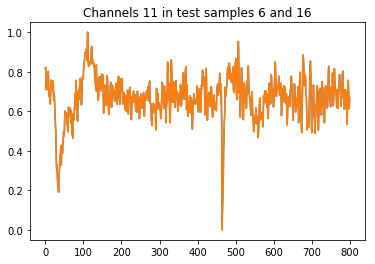

In [119]:
# inspect channel 11
%matplotlib inline
plt.plot(range(0, 800), x_test[15,10,:,0], range(0, 800), x_test[15,10,:,0])
ax = plt.gca()
ax.set_title("Channels 11 in test samples 6 and 16")

In [125]:
# Training time!

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=40,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

# save the entire model and the weights after the training:
autoencoder.save('my_model.h5')
autoencoder.save_weights('my_model_weights.h5')

Train on 72 samples, validate on 18 samples
Epoch 1/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6789 - val_loss: 0.6774
Epoch 2/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6781 - val_loss: 0.6774
Epoch 3/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6782 - val_loss: 0.6772
Epoch 4/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6778 - val_loss: 0.6778
Epoch 5/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6787 - val_loss: 0.6772
Epoch 6/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6772 - val_loss: 0.6771
Epoch 7/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6770 - val_loss: 0.6778
Epoch 8/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6779 - val_loss: 0.6814
Epoch 9/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6799 - val_loss: 0.6787
Epoch 10/100
72/72 [==============================] - 0s 3ms/step

72/72 [==============================] - 0s 3ms/step - loss: 0.6815 - val_loss: 0.6775
Epoch 83/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6773 - val_loss: 0.6768
Epoch 84/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6766 - val_loss: 0.6776
Epoch 85/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6775 - val_loss: 0.6810
Epoch 86/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6796 - val_loss: 0.6786
Epoch 87/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6788 - val_loss: 0.6823
Epoch 88/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6802 - val_loss: 0.6768
Epoch 89/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6766 - val_loss: 0.6772
Epoch 90/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6771 - val_loss: 0.6796
Epoch 91/100
72/72 [==============================] - 0s 3ms/step - loss: 0.6783 - val_loss: 0.6786
Epoch 92/100


In [126]:
# let's predict a TRAINING sammple:
decoded_train = autoencoder.predict(x_train)
decoded_test = autoencoder.predict(x_test)
print(decoded_train.shape)
print(decoded_test.shape)

(72, 60, 800, 1)
(18, 60, 800, 1)


Pearson's R: [ 0.70438021] p-value [ 0.]


Text(0.5,1,'Original')

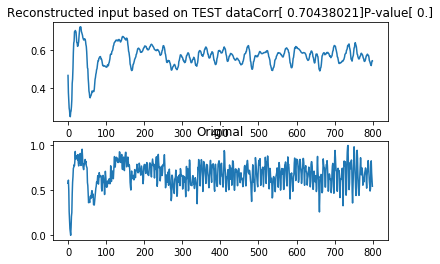

In [128]:
reconstruct_training_sample = False
chan = 30
samp = 5

from scipy.stats import pearsonr
# now let's see how the model performs:

if (reconstruct_training_sample==True):
    reconst = decoded_train[samp,chan,:,:].reshape(800,1)
    orig = x_train[samp,chan,:,:].reshape(800,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TRAINING data" + "Corr"+ str(R) + "P-value" + str(p)
else:
    reconst = decoded_test[samp,chan,:,:].reshape(800,1)
    orig = x_test[samp,chan,:,:].reshape(800,1)
    R,p = pearsonr(reconst, orig)
    title = "Reconstructed input based on TEST data" + "Corr"+ str(R) + "P-value" + str(p)


print("Pearson's R:", R, "p-value", p)
%matplotlib inline
plt.subplot(211)
plt.plot(reconst)
ax = plt.gca()
ax.set_title(title)
plt.subplot(212)
plt.plot(orig)
ax = plt.gca()
ax.set_title("Original")